In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=100, replications=20, n=500,
    allowed_functions=['identity']
)
data

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,sigma_X,sigma_Y,g_Z_X,g_U_X,g_X_Y,g_U_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y
0,920844,-0.768991,0.622719,-5.0,-0.821704,0.351799,1.151474,tanh,tanh,log1p_abs,exp_neg_sq,-2.188871,0.000,-2.688339,-0.499468,"[-0.7042389642361606, -0.12194428187493132, -0...","[0.2527719981752481, 1.6265269068465775, 0.964...","[1.210850036019212, 0.8653313767715042, 0.9200...","[-4.724778253741711, -3.3464539640616278, -1.6..."
1,979935,1.589599,-0.441784,-5.0,-1.270472,1.004072,0.983270,identity,log1p_abs,sin,exp_neg_sq,0.217884,0.520,-0.506683,-0.724568,"[-0.013664489398554934, 0.6508514229467047, 0....","[-0.03363100288977661, -1.826433593160375, 0.7...","[0.02334812744876162, 1.9491267488011645, 2.15...","[-1.5050874933347105, -5.351117882182592, -3.6..."
2,588496,1.105074,0.817591,-5.0,-1.025375,1.854611,0.964368,sin,log1p_abs,log1p_abs,log1p_abs,-4.378323,0.000,-4.955619,-0.577296,"[-0.39478587824738454, -0.36182602762799515, -...","[0.34208461684722763, -0.19498552212106537, -0...","[-3.7554049169435926, -3.681896016763318, -1.0...","[-8.699798583202927, -6.180668413978277, -5.21..."
3,370930,-0.789328,0.570575,-5.0,0.574127,1.408567,1.507230,exp_neg_sq,exp_neg_sq,exp_neg_sq,tanh,2.760160,1.000,-2.244994,-5.005154,"[-0.7408005692310777, -0.705602639719727, 0.61...","[-0.30416481459376626, -0.7368598191296846, 0....","[0.820070883187652, -0.09942982990742535, -0.3...","[-2.1492476692771136, -5.446081608639153, -5.4..."
4,410938,0.327097,0.222437,-5.0,-1.594576,2.049837,0.203056,identity,identity,sin,cos,-0.192506,0.474,-1.203626,-1.011120,"[-1.3031768174129248, 0.12398340657214009, -1....","[0.9895612031444814, 0.9806614926198057, 0.851...","[1.7210124073170103, -0.02989568290728445, 3.2...","[-5.90695672080206, -1.1994965237211535, -0.45..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,294931,-1.627618,-0.686400,5.0,0.369067,0.173583,1.040003,sigmoid,exp_neg_sq,exp_clipped,exp_neg_sq,-3.341192,0.000,1.875155,5.216347,"[0.8696227979871515, -0.8475116095981978, 0.70...","[0.6285696629023007, 0.5649919519237045, -0.95...","[-1.3526836693703181, -0.9554376618577785, -1....","[0.35789577168700637, 3.6379838887440297, 0.36..."
1996,44806,0.273797,0.304515,5.0,-0.076367,0.282643,0.433891,sin,sin,sigmoid,cos,-0.007525,0.482,2.446880,2.454405,"[0.7608398623616754, 0.7987681161509789, -0.49...","[2.2471912353538244, 0.9475647417248054, -0.10...","[0.3825229263696933, 0.49239595897620586, -0.3...","[2.5932387942505293, 3.516547035883929, 2.0006..."
1997,277051,-0.449571,2.065445,5.0,0.135927,2.345437,0.993343,exp_clipped,log1p_abs,cos,log1p_abs,-4.608414,0.000,0.462818,5.071232,"[0.6004655127531855, 0.2776655288146223, 1.665...","[-0.16923033552152011, 0.01234964970783826, -0...","[1.4868085142626497, 1.833487727418148, -3.803...","[-0.862870161882144, -2.633860700817313, -4.98..."
1998,467401,1.190128,0.858681,5.0,0.150844,1.087507,0.840111,tanh,identity,exp_clipped,tanh,13.126947,0.484,18.125681,4.998734,"[2.1631314910641084, 0.37892890903659604, -0.2...","[2.111851310166583, -0.5277270550188706, 0.524...","[0.9971428732966423, 1.4699036773444856, 0.506...","[12.663831107034351, 22.280297365511135, 9.564..."


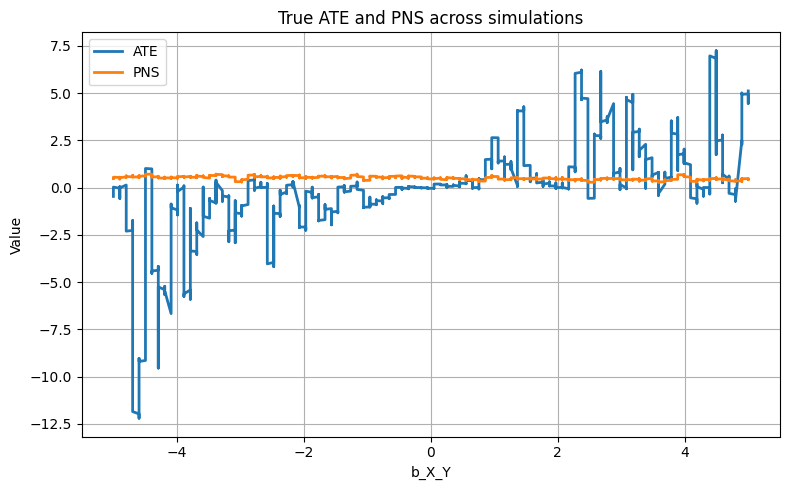

In [95]:
PlottingUtil.plot_ate_pns(data, window=30)

In [4]:
binaryIV = BinaryIV('IV Dag', data)

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run_all_bounding_algorithms(algorithms)

Running ATE_2SLS-0.99...
ATE_2SLS-0.99 completed in 0.19 seconds.
Running ATE_2SLS-0.98...
ATE_2SLS-0.98 completed in 0.25 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 6.28 seconds.
Running ATE_autobound...
ATE_autobound completed in 4.71 seconds.
Running ATE_entropybounds-0.80...
ATE_entropybounds-0.80 completed in 0.59 seconds.
Running ATE_entropybounds-0.20...
ATE_entropybounds-0.20 completed in 0.59 seconds.
Running ATE_entropybounds-0.10...
ATE_entropybounds-0.10 completed in 0.63 seconds.
Running ATE_nonpara...
ATE_nonpara completed in 0.01 seconds.
Total runtime: 13.26 seconds.


             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
           PNS_nonpara          0.00            16.00          0.1784
       PNS_causaloptim          4.00             9.38          0.4198
         PNS_autobound          1.00             0.00          0.4283
PNS_entropybounds-0.10          0.00             0.00          0.5021
PNS_entropybounds-0.20          0.00             0.00          0.5752
PNS_entropybounds-0.80          0.00             0.00          0.7197
    PNS_zaffalonbounds           N/A              N/A             N/A


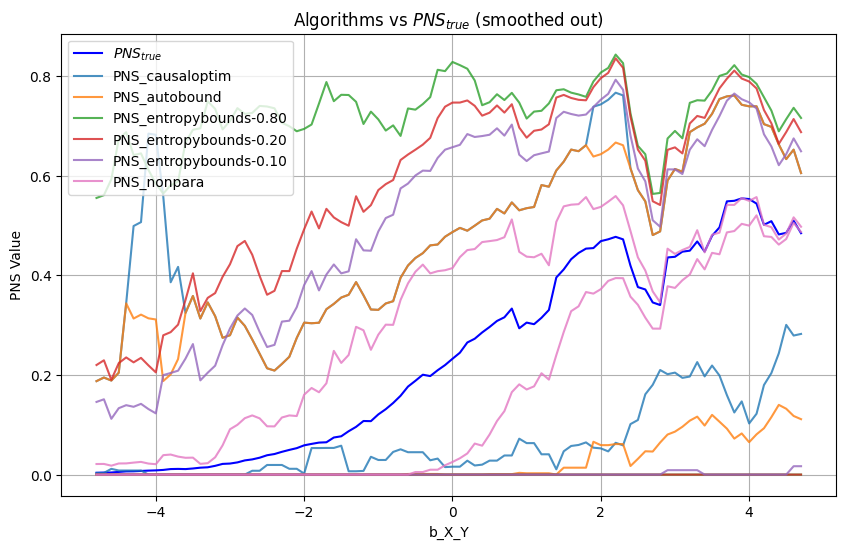

In [28]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('PNS')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'PNS', ate_algs, 5, False)